# KNN for Loan Default Predictions

Install xlrd for Excel support and import the core analysis, plotting, and k-NN libraries.

In [23]:
%pip install xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

Note: you may need to restart the kernel to use updated packages.


Load the credit default dataset from Excel, rename the target column to TARGET, and preview the data.

In [24]:
DATA_FILE = "default of credit card clients.xls"

raw_df = (
    pd.read_excel(DATA_FILE, header=1)
    .rename(columns={"default payment next month": "TARGET"})
)

raw_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1.1 Prepare Data

Split the dataframe into feature columns (X) and the TARGET labels (y), then display both.

In [25]:
X = raw_df.drop(columns = 'TARGET')

y = raw_df['TARGET']

display(X,y)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,2,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,3,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,4,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,5,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,3502,8979,5190,0,1837,3526,8998,129,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,2758,20878,20582,19357,0,0,22000,4200,2000,3100
29998,29999,80000,1,3,1,41,1,-1,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804


0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: TARGET, Length: 30000, dtype: int64

### 1.2(a) Split data

Create an 80/20 train-test split with a fixed seed and then carve out a validation fold from the training data for threshold tuning.


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    stratify=y,
)  # 20% of data is test here

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,
    random_state=0,
    stratify=y_train,
)  # carve out a validation fold (20% of original data) for threshold tuning

display(X_train_sub.shape, X_val.shape, X_test.shape, y_train_sub.shape, y_val.shape, y_test.shape)


(24000, 24)

(6000, 24)

(24000,)

(6000,)

### 1.2(b) Scale features

Standardize features using training-fold statistics and confirm the means and standard deviations of the scaled sets.


In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                           # define the scaler

scaler.fit(X_train_sub)                             # train the scaler on training fold only
X_train_scaled = scaler.transform(X_train_sub)      # apply the scaler to transform the training data
X_val_scaled = scaler.transform(X_val)              # transform validation data
X_test_scaled = scaler.transform(X_test)            # apply the scaler to transform test data

dataframe_scaled = pd.DataFrame(np.round(X_train_scaled, 2), columns=X.columns)
dataframe_scaled
dataframe_scaled.describe()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,-0.000003,0.000117,-0.003620,0.000859,0.002000,-0.000125,-0.000977,0.000947,-0.002232,-0.002345,...,-0.000072,0.000457,-0.000554,0.000649,0.000344,0.000498,0.000262,0.000253,-0.000743,-0.000825
std,1.000035,0.999819,0.998924,1.000731,1.000777,1.000235,1.001321,0.999770,1.000414,1.000503,...,1.000092,0.999732,1.000429,0.999624,0.999882,0.999877,0.999920,0.999933,1.000227,1.000271
min,-1.730000,-1.220000,-1.230000,-2.350000,-2.980000,-1.570000,-1.760000,-1.560000,-1.540000,-1.530000,...,-2.940000,-3.320000,-2.010000,-6.370000,-0.340000,-0.250000,-0.300000,-0.310000,-0.320000,-0.300000
25%,-0.870000,-0.910000,-1.230000,-1.080000,-1.060000,-0.810000,-0.880000,-0.730000,-0.700000,-0.670000,...,-0.640000,-0.640000,-0.640000,-0.630000,-0.280000,-0.220000,-0.280000,-0.290000,-0.300000,-0.290000
50%,0.000000,-0.210000,0.810000,0.190000,0.860000,-0.160000,0.010000,0.110000,0.130000,0.180000,...,-0.390000,-0.380000,-0.370000,-0.370000,-0.220000,-0.170000,-0.200000,-0.220000,-0.220000,-0.210000
75%,0.870000,0.560000,0.810000,0.190000,0.860000,0.600000,0.010000,0.110000,0.130000,0.180000,...,0.190000,0.170000,0.160000,0.170000,-0.040000,-0.040000,-0.040000,-0.050000,-0.050000,-0.070000
max,1.730000,4.880000,0.810000,5.260000,2.780000,4.740000,7.110000,5.940000,6.810000,7.030000,...,23.260000,10.340000,12.910000,11.120000,52.230000,71.610000,51.430000,39.800000,25.270000,29.640000


## 1.3  Modeling


### 1.3(a) find best K

Set up a k-NN classifier and run a 5-fold grid search over odd k values to find the best parameter.

In [28]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

k_range = {'n_neighbors': np.arange(1,80,2)}                            #  k = 1,3,5, ... 83

grid = GridSearchCV(estimator = knn, param_grid = k_range, cv = 5)      # 5-CV on train (105 - sub_train 84 + validation 21)

grid.fit(X_train_scaled, y_train_sub)       # search over the values on Train data (with 5-cv)

best_param = grid.best_params_          # k value that returns highest mean cv score during cv
best_cv_score = grid.best_score_        # mean cv score of the best k

print("Best Params: {}".format(best_param))
print("Mean cv score of the best k: {:.2%}".format(best_cv_score))


Best Params: {'n_neighbors': np.int64(21)}
Mean cv score of the best k: 81.12%


### 1.3(b) Visualize mean cv scores for each k value

Plot mean cross-validation accuracy versus k to visualize how performance changes with neighborhood size.

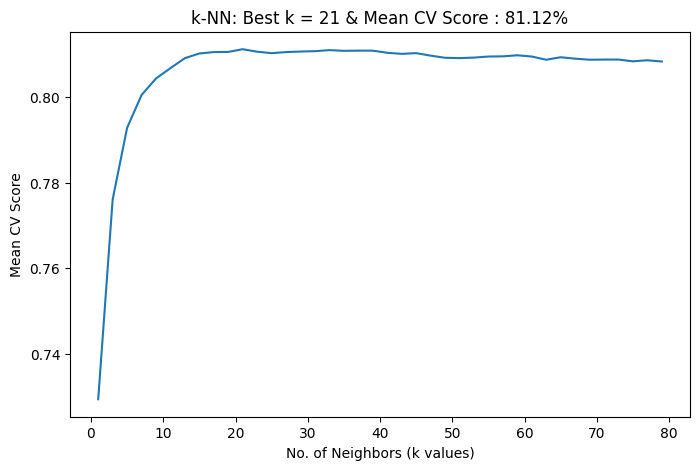

In [29]:
k_values = grid.cv_results_['param_n_neighbors']        # k values, same as k_range['n_neighbors']
cv_scores = grid.cv_results_['mean_test_score']         # mean cv scores for each k   

plt.figure(figsize = (8, 5))
plt.plot(k_values,  cv_scores)        # a line plot (default blue solid line)
plt.xlabel('No. of Neighbors (k values)')
plt.ylabel('Mean CV Score')
plt.title('k-NN: Best k = {} & Mean CV Score : {:.2%}'.format(best_param['n_neighbors'], best_cv_score))
plt.show()

Compute average credit limits for defaulters and non-defaulters to ground the cost assumptions.

In [35]:
# 1. Separate defaulters vs non-defaulters
df_default    = raw_df[raw_df["TARGET"] == 1]  # will default
df_no_default = raw_df[raw_df["TARGET"] == 0]  # will NOT default

# 2. Typical credit limit (principal proxy)
mean_limit_default    = df_default["LIMIT_BAL"].mean()
mean_limit_no_default = df_no_default["LIMIT_BAL"].mean()

print("Avg credit limit (default):    ", mean_limit_default)
print("Avg credit limit (no default):", mean_limit_no_default)

Avg credit limit (default):     130109.65641952984
Avg credit limit (no default): 178099.72607430234


Apply the PDF's six-month observation window and APR assumptions to derive per-period profit/loss inputs for the cost matrix.


In [36]:
# Business assumptions grounded in the PDF's six-month observation window
# April–September 2005 appears in the data dictionary PDF, so model six monthly billing cycles.
assumption_config = {
    "annual_apr": 0.18,             # 18% annual percentage rate from the referenced credit card PDF
    "periods_per_year": 12,        # monthly compounding
    "observation_months": 6,       # six billing cycles in the PDF window (Apr–Sep 2005)
    "loss_given_default": 0.5,     # lose 50% of the limit if they default
}

annual_apr = assumption_config["annual_apr"]
periods_per_year = assumption_config["periods_per_year"]
observation_months = assumption_config["observation_months"]
loss_given_default = assumption_config["loss_given_default"]

periodic_rate = annual_apr / periods_per_year
period_length_months = 12 / periods_per_year
periods_in_window = observation_months / period_length_months

# Approx profit from approving a good customer (non-defaulter) over the observation window
profit_good = mean_limit_no_default * ((1 + periodic_rate) ** periods_in_window - 1)

# Approx loss from approving a bad customer (defaulter)
loss_bad = mean_limit_default * loss_given_default

print("Periodic rate: {:.2%}".format(periodic_rate))
print("Approx profit per good customer: {:.2f}".format(profit_good))
print("Approx loss per bad customer:    {:.2f}".format(loss_bad))


Approx profit per good customer:  3561.994521486047
Approx loss per bad customer:     65054.82820976492


Construct a cost/benefit matrix that maps actual/predicted outcomes to monetary values using the assumptions.

In [37]:
# 3. Cost/benefit matrix driven by the data

# Story:
# TARGET=1 = will default
# Prediction=1 = treat as risky (reject / restrict credit)
# Prediction=0 = treat as safe (approve / keep credit)

value_TN =  profit_good   # Actual 0, Pred 0: good customer, approved → earn interest
value_FP = -profit_good   # Actual 0, Pred 1: good customer, rejected → lose that profit
value_FN = -loss_bad      # Actual 1, Pred 0: bad customer, approved → lose money
value_TP =  0.0           # Actual 1, Pred 1: bad customer, rejected → avoided loss, no loan

value_matrix = pd.DataFrame(
    {
        0: {0: value_TN, 1: value_FN},  # Predicted 0
        1: {0: value_FP, 1: value_TP},  # Predicted 1
    }
)
value_matrix.index.name = "Actual"
value_matrix.columns.name = "Predicted"

value_matrix

Predicted,0,1
Actual,,
0,3561.994521,-3561.994521
1,-65054.828210,0.000000


Define a helper that summarizes classification metrics, rates, AUCs, and optional utility for a model.

In [39]:
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)

import numpy as np
import pandas as pd


def summarize_model(
    model_name,
    dataset_name,
    y_true,
    y_pred,
    y_score,
    threshold,
    utility_fn=None,
):
    '''Return a one-row DataFrame with key classification metrics.'''
    y_true_arr = np.asarray(y_true).ravel()
    y_pred_arr = np.asarray(y_pred).ravel()

    score_arr = None
    if y_score is not None:
        score_arr = np.asarray(y_score)
        if score_arr.ndim > 1:
            score_arr = score_arr[:, -1]
        score_arr = score_arr.ravel()

    tn, fp, fn, tp = confusion_matrix(
        y_true_arr, y_pred_arr, labels=[0, 1]
    ).ravel()
    total = tn + fp + fn + tp

    def _safe_div(num, denom):
        return num / denom if denom else np.nan

    fprate = _safe_div(fp, fp + tn)
    fnrate = _safe_div(fn, fn + tp)
    approval_rate = _safe_div(tn + fn, total)
    rejection_rate = _safe_div(fp + tp, total)

    roc_auc = np.nan
    pr_auc = np.nan
    if score_arr is not None and len(np.unique(y_true_arr)) > 1:
        try:
            roc_auc = roc_auc_score(y_true_arr, score_arr)
        except ValueError:
            pass
        try:
            pr_auc = average_precision_score(y_true_arr, score_arr)
        except ValueError:
            pass

    precision = precision_score(y_true_arr, y_pred_arr, zero_division=0)
    recall = recall_score(y_true_arr, y_pred_arr, zero_division=0)
    f1 = f1_score(y_true_arr, y_pred_arr, zero_division=0)

    utility_total = np.nan
    utility_per_app = np.nan
    if utility_fn is not None:
        utility_result = utility_fn(tn, fp, fn, tp)
        if isinstance(utility_result, dict):
            utility_total = utility_result.get('utility_total', np.nan)
            utility_per_app = utility_result.get('utility_per_app', np.nan)
        elif isinstance(utility_result, (tuple, list)):
            if len(utility_result) >= 2:
                utility_total, utility_per_app = utility_result[:2]
            elif len(utility_result) == 1:
                utility_total = utility_result[0]
        else:
            utility_total = utility_result

        try:
            needs_per_app = np.isnan(utility_per_app)
        except TypeError:
            needs_per_app = False

        if needs_per_app:
            utility_per_app = _safe_div(utility_total, total)

    summary = {
        'model_name': model_name,
        'dataset_name': dataset_name,
        'threshold': threshold,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'TP': tp,
        'fprate': fprate,
        'fnrate': fnrate,
        'approval_rate': approval_rate,
        'rejection_rate': rejection_rate,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'utility_total': utility_total,
        'utility_per_app': utility_per_app,
    }

    return pd.DataFrame([summary])

Find the probability threshold that maximizes expected utility using validation data and summarize the tuned model on the test data.


In [42]:
# Summarize the tuned k-NN model using a validation-tuned threshold on the held-out test data

def _knn_utility(tn, fp, fn, tp):
    total = (tn * value_TN) + (fp * value_FP) + (fn * value_FN) + (tp * value_TP)
    total_apps = tn + fp + fn + tp
    per_app = total / total_apps if total_apps else np.nan
    return {
        'utility_total': total,
        'utility_per_app': per_app,
    }


y_score_val = grid.predict_proba(X_val_scaled)[:, 1]
_knn_model_name = "k-NN (k={})".format(grid.best_params_['n_neighbors'])

threshold_grid = np.linspace(0.0, 1.0, 101)
threshold_summaries = []
for _thr in threshold_grid:
    y_pred_thr = (y_score_val >= _thr).astype(int)
    threshold_summaries.append(
        summarize_model(
            model_name=_knn_model_name,
            dataset_name="Validation",
            y_true=y_val,
            y_pred=y_pred_thr,
            y_score=y_score_val,
            threshold=_thr,
            utility_fn=_knn_utility,
        )
    )

threshold_results = pd.concat(threshold_summaries, ignore_index=True)

best_idx = threshold_results['utility_per_app'].fillna(-np.inf).idxmax()
best_threshold = threshold_results.loc[best_idx, 'threshold']

y_score_test = grid.predict_proba(X_test_scaled)[:, 1]
y_pred_best = (y_score_test >= best_threshold).astype(int)
knn_summary_df = summarize_model(
    model_name=_knn_model_name,
    dataset_name="Test",
    y_true=y_test,
    y_pred=y_pred_best,
    y_score=y_score_test,
    threshold=best_threshold,
    utility_fn=_knn_utility,
)

print(best_threshold)

knn_summary_df


0.05


,model_name,dataset_name,threshold,TN,FP,FN,TP,fprate,fnrate,approval_rate,rejection_rate,roc_auc,pr_auc,precision,recall,f1,utility_total,utility_per_app
0,k-NN (k=21),Test,0.05,1178,3525,110,1187,0.749522,0.084811,0.214667,0.785333,0.740563,0.482676,0.25191,0.915189,0.395074,-1.551603e+07,-2586.005374


### 1.3(c) Evaluate and apply the best model (validation-tuned)

Use the validation-tuned threshold to generate test-set predictions and view the label counts.


In [ ]:
y_pred_test = y_pred_best

display(y_test, y_pred_test)


### 2. Model Evaluation

Confusion matrix based on the tuned threshold.


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=[0,1])


Tabulate the raw confusion matrix counts for the test set using the tuned cutoff.


In [ ]:
cm_counts = pd.crosstab(
    y_test,
    y_pred_test,
    rownames=['Actual'],
    colnames=['Predicted'],
    dropna=False
)

cm_counts


Convert confusion matrix counts into probabilities for expected-value calculations driven by the tuned model.


In [ ]:
# 2.2 Convert confusion matrix counts to probabilities (expected rates)

N = cm_counts.to_numpy().sum()     # total number of test samples
cm_prob = cm_counts / N            # element-wise division

cm_prob


Calculate expected value per applicant and for the full test set using the tuned confusion matrix.


In [ ]:
# 2.4 Expected value per person and in total

# EV per person = sum over all cells of [probability * value]
ev_per_person = (cm_prob * value_matrix).to_numpy().sum()

# EV over all people in the test set (just multiply by N)
ev_total = ev_per_person * N

print("Expected value per person: {:.2f}".format(ev_per_person))
print("Expected value over all {} test customers: {:.2f}".format(N, ev_total))
